In [13]:
from fonctions_image import *
import cv2

# Variables
url = "http://10.220.14.33:8080/video"
puzzle_image_path = "../nos_puzzles/yakari.jpg"
puzzle_chateau_path = "../nos_puzzles/chateau.jpg"
verbose = True

### Sift

In [14]:
# Chargement
cap = start_camera(url)
sift, bf, target_image, keypoints_full, descriptors_full = load_image_sift_knn(puzzle_image_path)
sift_chateau, bf_chateau, target_image_chateau, keypoints_full_chateau, descriptors_full_chateau = load_image_sift_knn(puzzle_chateau_path)

Successfully connected to camera at http://10.220.14.33:8080/video


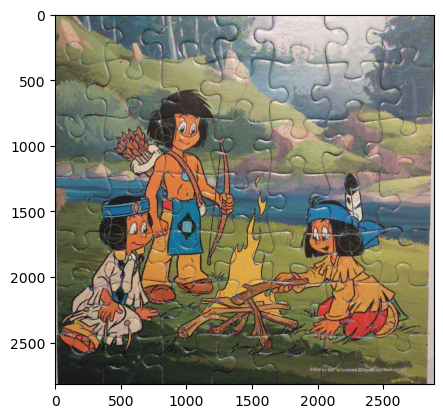

In [39]:
img_with_keypoints = cv2.drawKeypoints(target_image, keypoints_full, None,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
yakari_with_keypoints = cv2.cvtColor(img_with_keypoints, cv2.COLOR_BGR2RGB)
plt.imshow(yakari_with_keypoints)

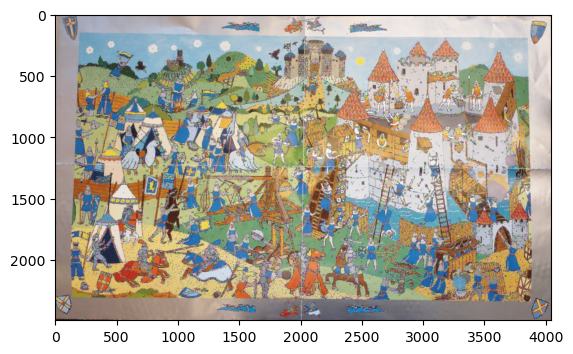

In [22]:
chateau_with_keypoints = cv2.drawKeypoints(target_image_chateau, keypoints_full_chateau, None)
chateau_with_keypoints = cv2.cvtColor(chateau_with_keypoints, cv2.COLOR_BGR2RGB)
plt.imshow(chateau_with_keypoints)

In [17]:
frame = read_frame(cap)
print(frame.shape)

(1080, 1920, 3)


True

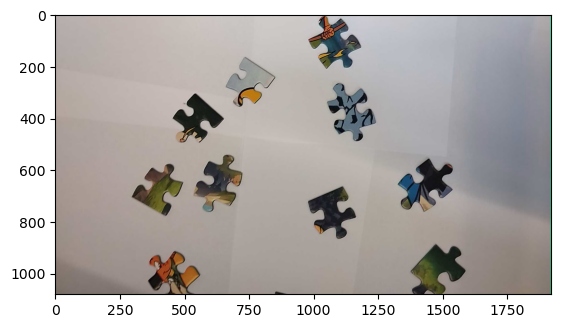

In [ ]:
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
plt.imshow(frame)
cv2.imwrite("yakari_test_2.jpg", frame)

## Extract pieces

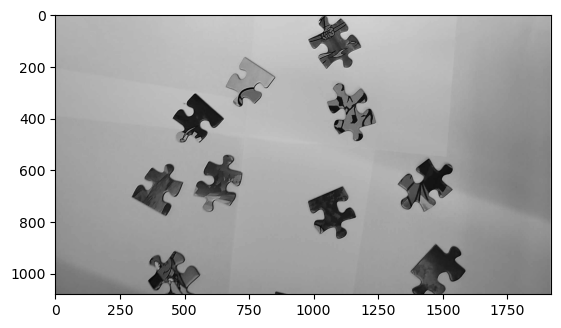

In [27]:
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
plt.imshow(gray, cmap='gray')

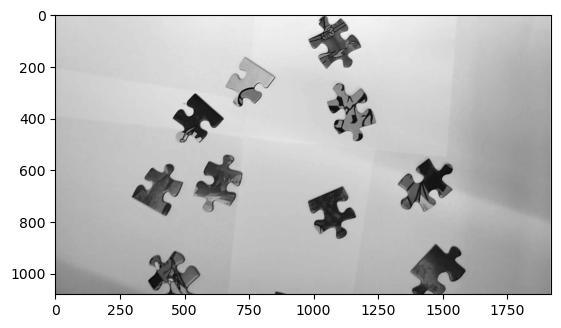

In [28]:
blurred = cv2.GaussianBlur(gray, (5, 5), 0)
plt.imshow(blurred, cmap='gray')

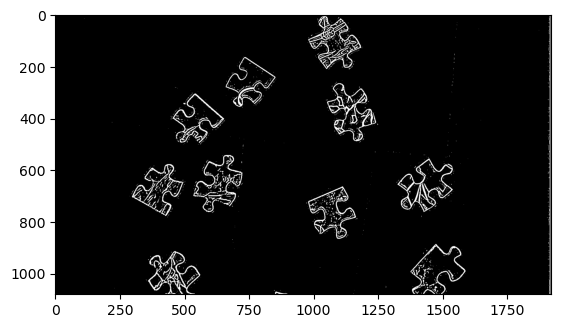

In [31]:
binary = cv2.adaptiveThreshold(
            blurred,
            255,
            cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
            cv2.THRESH_BINARY_INV,
            blockSize=11,  # Must be odd number
            C=2  # Constant subtracted from mean
        )
plt.imshow(binary, cmap='gray')

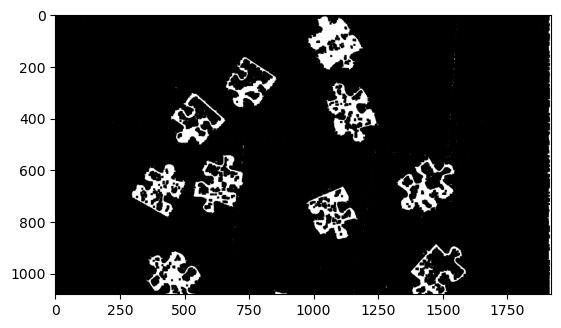

In [33]:
# Morphological operations with smaller kernel
kernel_small = np.ones((3, 3), np.uint8)
kernel_medium = np.ones((8, 8), np.uint8)
#kernel_large = np.ones((15, 15), np.uint8)

# Close small holes first
#morph = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel_large)
morph = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel_medium)
morph = cv2.morphologyEx(morph, cv2.MORPH_CLOSE, kernel_small)

plt.imshow(morph, cmap='gray')

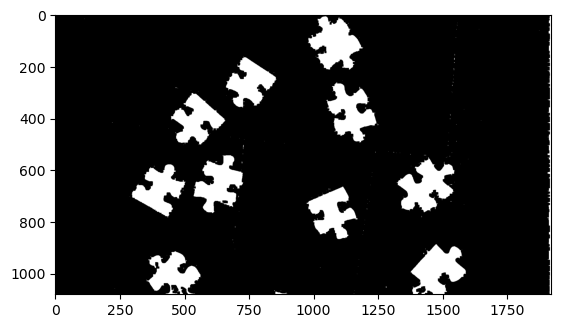

In [34]:
contours, _ = cv2.findContours(morph, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
mask = np.zeros_like(morph)

for contour in contours:
    # Fill each contour
    cv2.drawContours(mask, [contour], -1, 255, -1)

# Now mask has filled pieces without holes
morph = mask

plt.imshow(morph, cmap='gray')

In [35]:
pieces = extract_pieces(frame)

Found 10 valid pieces
Piece areas: [23880, 18904, 21940, 20019, 21984, 24161, 20159, 19455, 23312, 18068]



Piece 0:
Position: (959, 0)
Size: (254, 235)
Area: 23880

Piece 1:
Position: (642, 144)
Size: (235, 238)
Area: 18904

Piece 2:
Position: (1030, 243)
Size: (234, 273)
Area: 21940

Piece 3:
Position: (429, 285)
Size: (251, 238)
Area: 20019

Piece 4:
Position: (516, 525)
Size: (233, 263)
Area: 21984

Piece 5:
Position: (1303, 533)
Size: (263, 252)
Area: 24161

Piece 6:
Position: (277, 560)
Size: (248, 245)
Area: 20159

Piece 7:
Position: (954, 646)
Size: (237, 242)
Area: 19455

Piece 8:
Position: (1357, 868)
Size: (254, 212)
Area: 23312

Piece 9:
Position: (335, 895)
Size: (249, 185)
Area: 18068


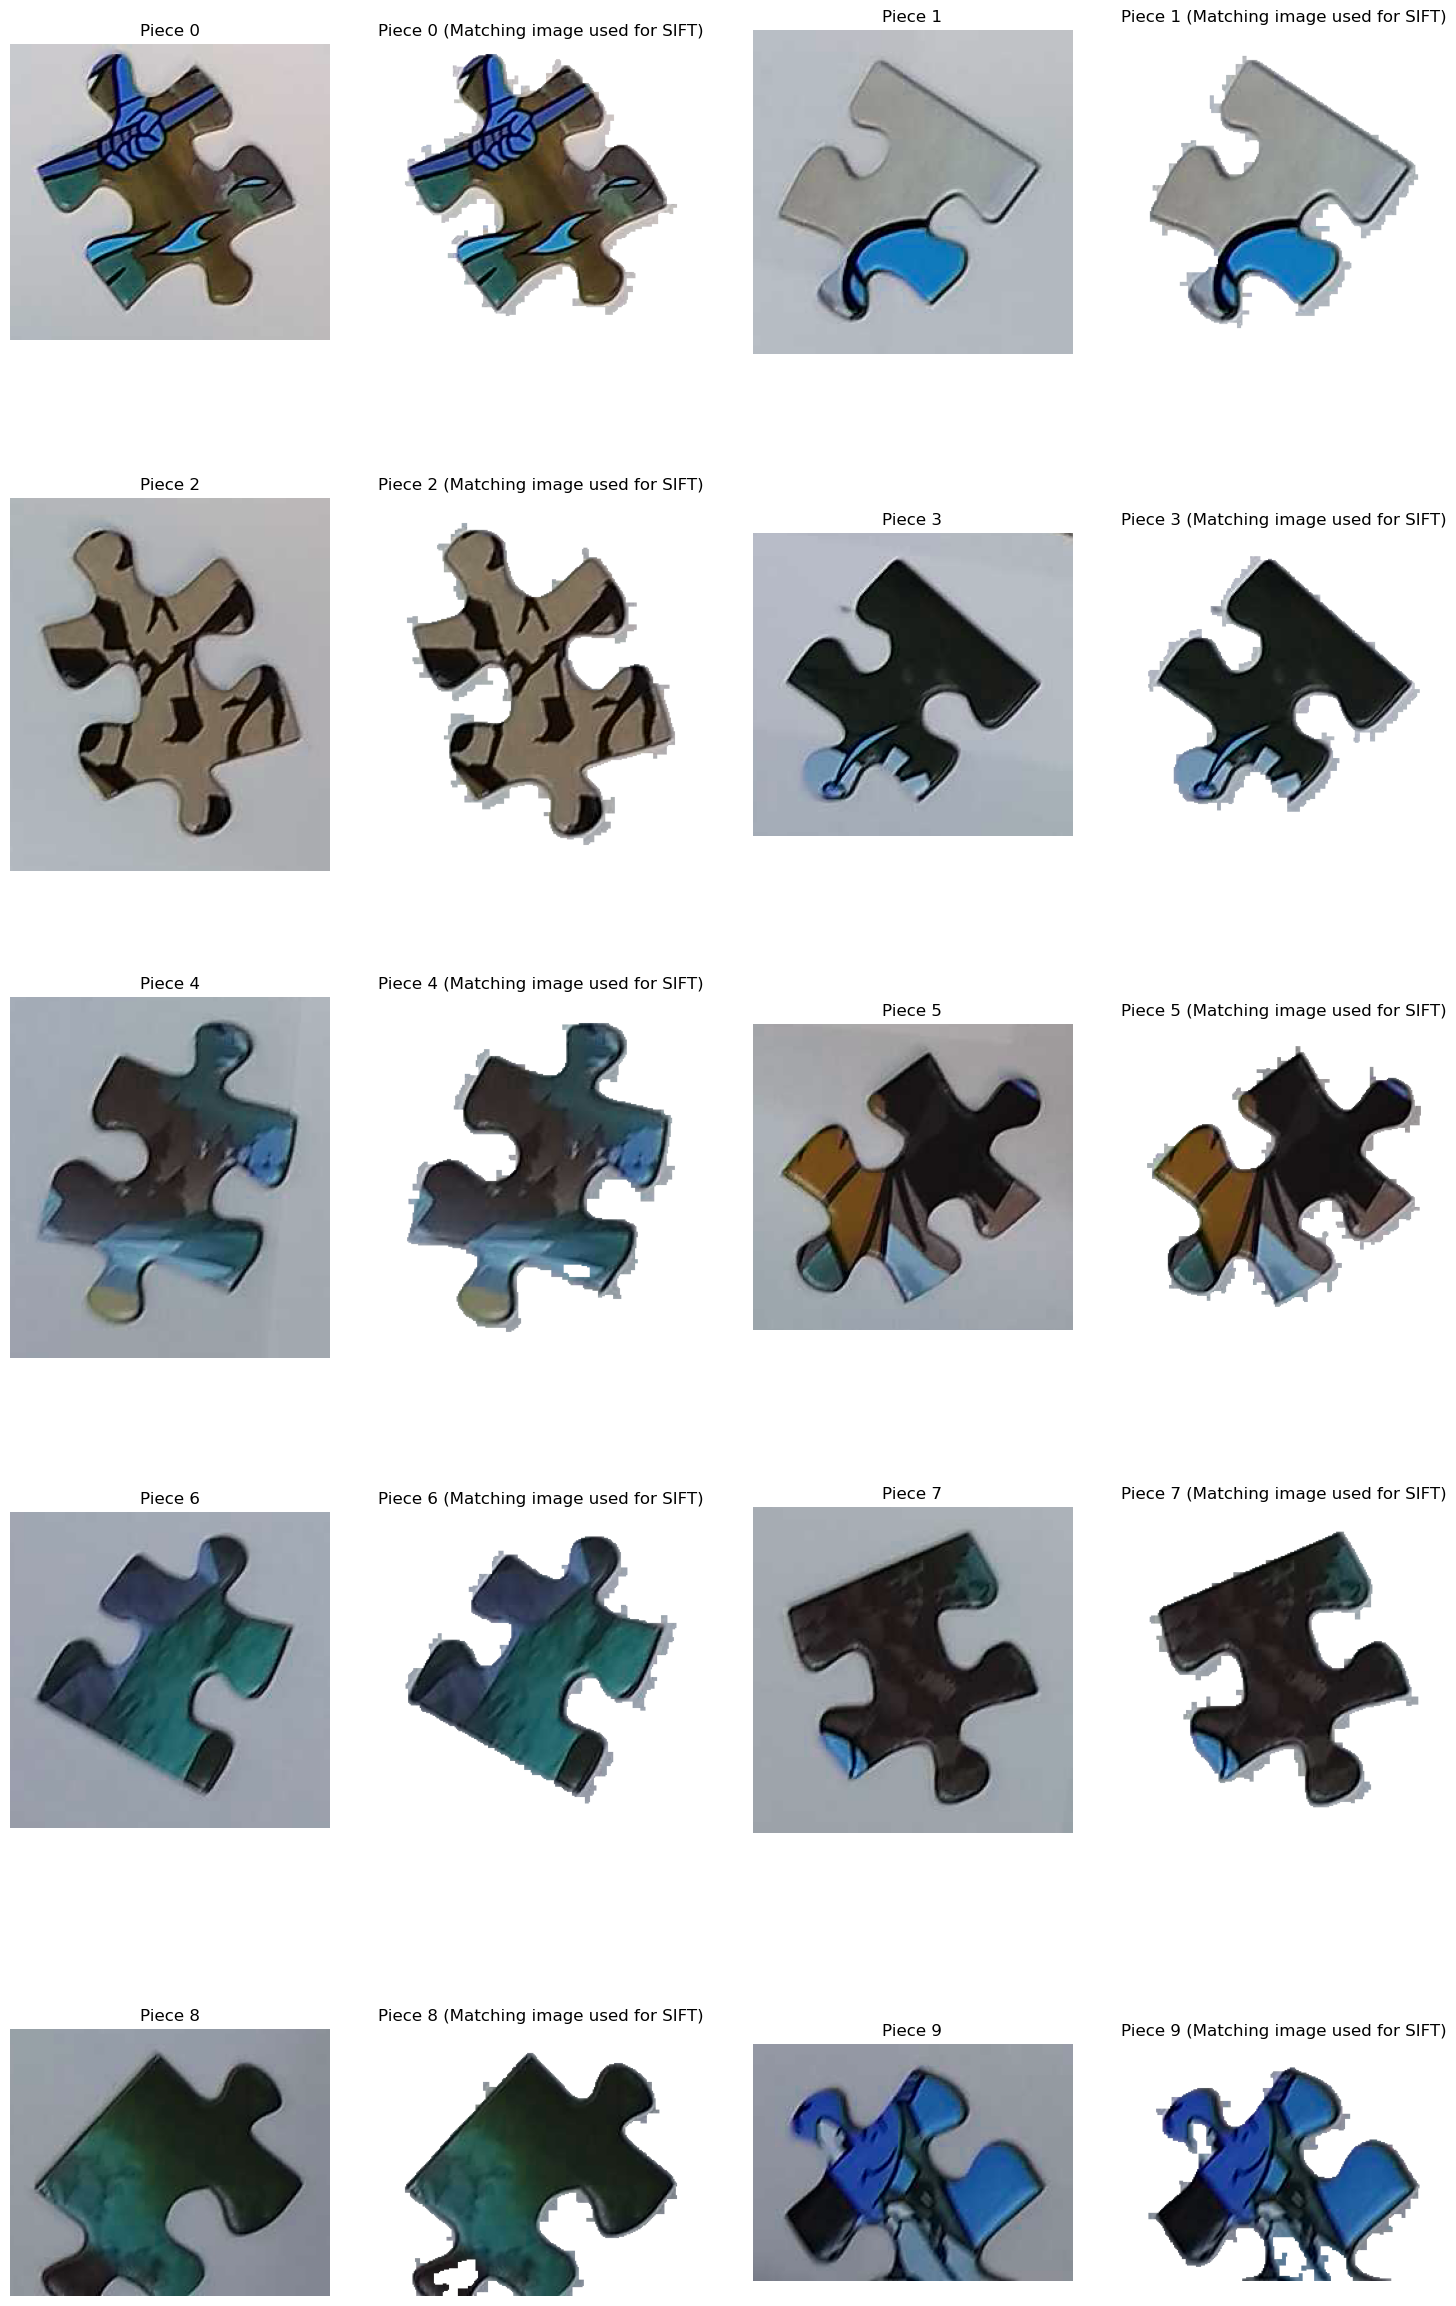

In [36]:
show_found_pieces(pieces)

## Piece analysis

### Baseline piece with high quality

Found 3 valid pieces
Piece areas: [117638, 586283, 303447]


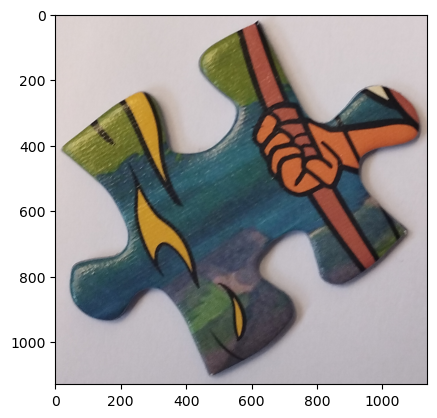

In [65]:
baseline = cv2.imread("yakari_bras.jpg")
baseline = cv2.cvtColor(baseline, cv2.COLOR_BGR2RGB)

baseline_pieces = extract_pieces(baseline)

baseline_piece = baseline_pieces[1]
plt.imshow(baseline_piece["image"])

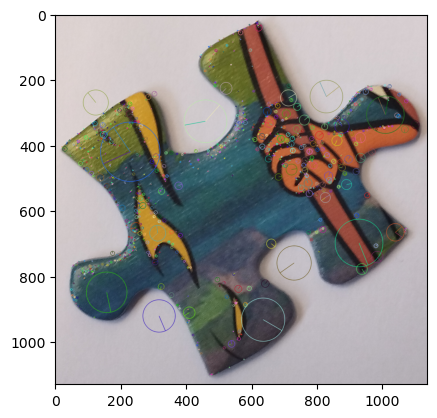

In [69]:
baseline_keypoints, baseline_descriptors = sift.detectAndCompute(baseline_piece['image'], None)
baseline_piece_keypoints = cv2.drawKeypoints(baseline_piece['image'], baseline_keypoints, baseline_piece['image'], flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.imshow(baseline_piece_keypoints)

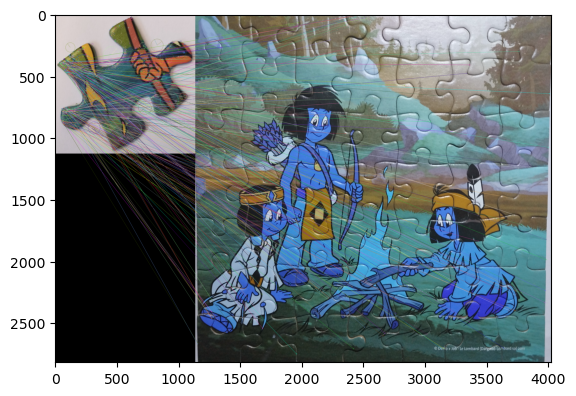

In [90]:
baseline_matches = bf.knnMatch(baseline_descriptors, descriptors_full, k=2)
baseline_match_img = cv2.drawMatchesKnn(baseline_piece['image'], baseline_keypoints, target_image, keypoints_full, baseline_matches[:100], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.imshow(baseline_match_img)

### With lowe's ratio test

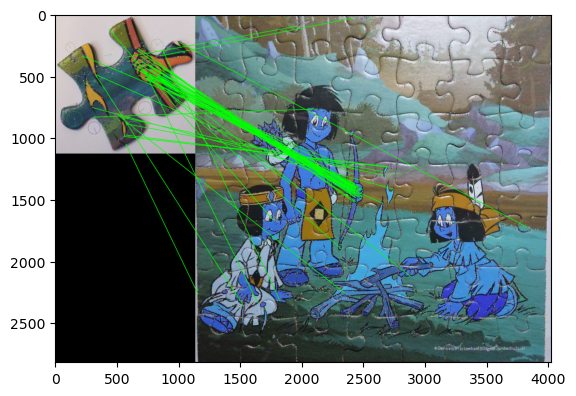

In [91]:
good_matches = []
for m, n in baseline_matches:
    if m.distance < 0.75 * n.distance:  # Lowe's ratio test
        good_matches.append(m)

# Then draw with OpenCV's function
matched_img = cv2.drawMatches(baseline_piece['image'], baseline_keypoints,
                            target_image, keypoints_full,
                            good_matches[:100], None,
                            matchColor=(0, 255, 0),
                            matchesThickness=3)
plt.imshow(matched_img)

### With mask

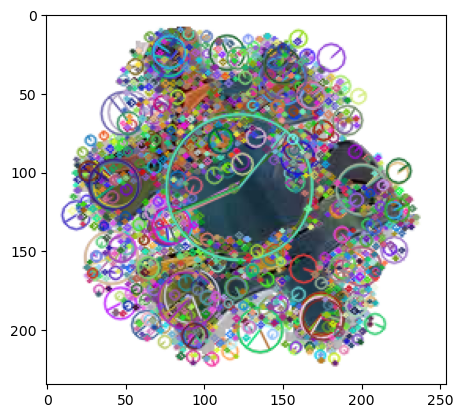

In [100]:
piece = pieces[0]
keypoints, descriptors = sift.detectAndCompute(piece['matching_image'], None)
piece_keypoints = cv2.drawKeypoints(piece['matching_image'], keypoints, piece['matching_image'], flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.imshow(piece_keypoints)

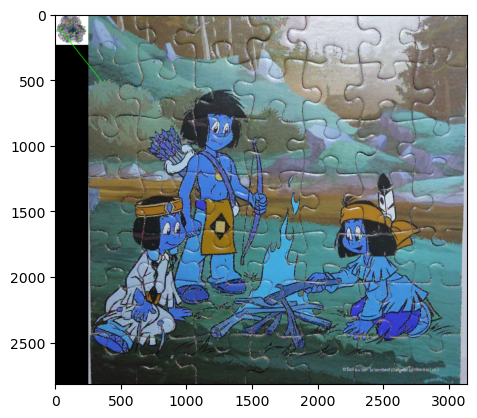

In [101]:
matches = bf.knnMatch(descriptors, descriptors_full, k=2)

good_matches = []
for m, n in matches:
    if m.distance < 0.75 * n.distance:  # Lowe's ratio test
        good_matches.append(m)
        
matched_img = cv2.drawMatches(piece['matching_image'], keypoints,
                            target_image, keypoints_full,
                            good_matches, None,
                            matchColor=(0, 255, 0),
                            matchesThickness=3)
plt.imshow(matched_img)

### Without mask

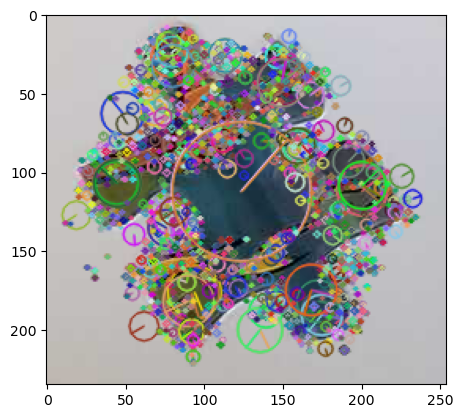

In [102]:
keypoints_nomask, descriptors_nomask = sift.detectAndCompute(piece['image'], None)
piece_keypoints_nomask = cv2.drawKeypoints(piece['image'], keypoints_nomask, piece['image'], flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.imshow(piece_keypoints_nomask)

Found 643 matches


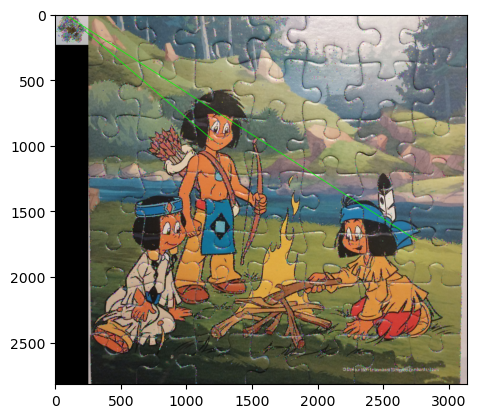

In [104]:
matches_nomask = bf.knnMatch(descriptors_nomask, descriptors_full, k=2)
print(f"Found {len(matches_nomask)} matches")

good_matches = []
for m, n in matches_nomask:
    if m.distance < 0.75 * n.distance:  # Lowe's ratio test
        good_matches.append(m)
        
matched_img = cv2.drawMatches(piece['image'], keypoints_nomask,
                            target_image, keypoints_full,
                            good_matches, None,
                            matchColor=(0, 255, 0),
                            matchesThickness=3)

match_img_nomask = cv2.cvtColor(matched_img, cv2.COLOR_BGR2RGB)
plt.imshow(match_img_nomask)